In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as im
import os
from PIL import Image
import glob
from pylab import arange
from scipy.ndimage import measurements

In [2]:
class System:
    '''this should track all atributes of the system'''
    
    def __init__(
        self,
        grid_size,
    ):
        #intitialize the grid as all solvent in the specified 
        #grid size
        self.data = np.zeros((grid_size,grid_size), dtype = int)
        self.polymers = []
        self.trajectory = []
        
    def add_polymers(self, polymer_number, polymer_length):
        
        polymer_list = []
        
        for i in range(polymer_number):
        
            polymer = Polymer(self.data,i+1,polymer_length)
           
            polymer_list.append(polymer)
            for cell in polymer.polymer_locations:
                self.data[cell[0]][cell[1]] = i+1
            self.polymers = polymer_list    
            
    def wriggle(self, number_of_wriggles):
        
        for number in range(number_of_wriggles):
            system_data = self.data
            random_poly = random.randint(0,len(self.polymers)-1)
            #polymer.neighbor_list()
            self.polymers[random_poly].make_a_move(system_data)
            self.update_system_data()
            
    def return_new_polymers(self, number_of_wriggles):
        
        #for number in range(number_of_wriggles):
        #    system_data = self.data
        #    random_poly = random.randint(0,len(self.polymers)-1)
        #    #polymer.neighbor_list()
        #    self.polymers[random_poly].make_a_move(system_data)
        #    self.update_system_data()    
        new_polymers = self.polymers
        temp_system = System(len(self.data[0]))
        temp_system.polymers = new_polymers
        temp_system.update_system_data()
        for number in range(number_of_wriggles):
            system_data = temp_system.data
            random_poly = random.randint(0,len(self.polymers)-1)
            temp_system.polymers[random_poly].make_a_move(system_data)
            temp_system.update_system_data()
            temp_system.polymers
        return temp_system.polymers
    
    def update_system_data(self):
        grid_size = len(self.data[0])
        #self.trajectory.append(self.data)
        self.data = np.zeros((grid_size,grid_size), dtype = int)
        for polymer in self.polymers:
            for x in range(len(polymer.polymer_dict)):
                cell = polymer.polymer_dict[x]
                self.data[cell[0]][cell[1]] = polymer.polymer_id

                
    def gif_the_system(self, period):
        
        if not os.path.exists('images'):
            os.makedirs('images')
            
           
    
        for i,frame in enumerate(self.trajectory):
                
            
            plt.figure(figsize=(10,10))
            fig = plt.imshow(frame)
            fig.figure.savefig("images/_" + str(i))
                

        
        frames = []
        imgs = glob.glob("images/*.png")
        for i in imgs:
            new_frame = Image.open(i)
            frames.append(new_frame)

        # Save into a GIF file that loops forever
        frames[0].save('trajectory.gif', format='GIF',
                       append_images=frames[1:],
                       save_all=True,
                       duration=3000, loop=0)
    
    
    def system_energy(self):
        "computes system energy from aggregating polymer energy"
        
        system_occupency = 0
        
        for polymer in self.polymers:
            
            polymer.neighbor_list(self.data)
            
            occupency = polymer.polymer_occupency
          
            system_occupency += occupency

        return(system_occupency)
    
    
    def return_largest_polymer_cluster_area(self):
        data = self.data
        new_data = self.data
        length = len(self.data[0])
        for i in range(length):
            for j in range(length):
                if data[i][j] != 0:
                    new_data[i][j] = 1
        lw, num = measurements.label(new_data)            
        area = measurements.sum(new_data, lw, index=arange(lw.max() + 1))
        max_polymer_area = np.max(area)
    
        #number_of_clusters = len(np.unique(area)) -1
        average_cluster_size = np.mean(area)
    
        clusters = [i for i in area if i != 0]
        number_of_clusters = len(clusters)
        average_cluster_size = np.mean(clusters)
    
        return max_polymer_area,average_cluster_size,number_of_clusters
    
    
    def return_largest_unoccupied_cluster_area(self):
        data = self.data
        new_data = self.data
        length = len(self.data[0])
        for i in range(length):
            for j in range(length):
                if data[i][j] != 0:
                    new_data[i][j] = 5

        for i in range(length):
            for j in range(length):
                if new_data[i][j] == 0:
                    new_data[i][j] = 1                    
                    
        for i in range(length):
            for j in range(length):
                if new_data[i][j] == 5:
                    new_data[i][j] = 0                          
                    
                    
        lw, num = measurements.label(new_data)            
        area = measurements.sum(new_data, lw, index=arange(lw.max() + 1))
        max_polymer_area = np.max(area)
    
        #number_of_clusters = len(np.unique(area)) -1
        average_cluster_size = np.mean(area)
    
        clusters = [i for i in area if i != 0]
        number_of_clusters = len(clusters)
        average_cluster_size = np.mean(clusters)
    
        return max_polymer_area,average_cluster_size,number_of_clusters    

In [3]:
class Polymer:
    
    '''This class should track everything relevant to the polymer
    
    This should inlcude where it is. Wether is is A type or B (A and B being polymer type or solvent type 
    type. How many adjacent cells are occupied by monnomers of type A or B. And from this,
    its contribution the total energy, 
    
    '''
    
    def __init__(
        self,
        system_data,
        polymer_id,
        polymer_length
    ):
        self.polymer_locations =[]
        self.polymer_end_locations = []
        self.polymer_neighbors = []
        self.polymer_neighbors_not_inclusive = []
        self.polymer_id = polymer_id
        self.polymer_dict = {}
        self.polymer_occupency =[]
        
        
        empty = True
        edge_length = len(system_data[0])
        
        #grabs an empty cell at the top
        while empty == True:
            y = random.randint(0,edge_length-1)
            if system_data[0][y] == 0:
                system_data[0][y] = polymer_id
                empty = False
            
        self.polymer_end_locations.append([0,y])
        self.polymer_end_locations.append([polymer_length,y])
        
        for i in range(polymer_length):
            self.polymer_dict[i] = [i,y]
            self.polymer_locations.append([i,y])
 
        self.energy = None
        
    #def neighbor_occupency(self):
    #    
    #    """compute neighbor occupency"""
    #    
    #    #build neighborlist first
    #    #for every cell in the the neighborhood , if the id in the cell
    #    # is not 0 or self.id then self.neighbor_occupancy += 1abs
    #    neighbors = self.neighbor_list()
    #    occupency = 0
    #    for neighbor in neighbors:
    #        if system_data[neighbor[0]][neighbor[1]] != 0:
    #            occupency += 1
    #            
    #    self.polymer_occupency = occupency
    #    return occupency
#
        
    def neighbor_list(self,system_data):
        
        '''This function should take a polymer and return a list of its neighbors'''
        
        neighbors = []
        """
        for cell in self.polymer_locations:
            x = cell[0]
            y = cell[1]
            
            cell_neighbors = [[x,y-1],[x+1,y],[x-1,y],[x,y+1],]
            cell_neighbors_in_box = []
            
            edge_length = len(system_data[0])
            
            for neighbor in cell_neighbors:
                if (neighbor[0] >= 0 and neighbor[0] <= edge_length-1) and (neighbor[1] >= 0 and neighbor[1] <= edge_length-1):
                    neighbors.append(neighbor)
                    
        """
        
        length = len(self.polymer_dict)
        
        for i in range(length):
            
            x = self.polymer_dict[i][0]
            y = self.polymer_dict[i][1]
            
            cell_neighbors = [[x,y-1],[x+1,y],[x-1,y],[x,y+1],]

            

            
            for neighbor in cell_neighbors:
                #add neihbors to list if they in the bounds of the box
                if (neighbor[0] >= 0 and neighbor[0] <= length-1) and (neighbor[1] >= 0 and neighbor[1] <= length-1):
                    neighbors.append(neighbor) 
                    #dont add bonded neighbors
                    #if (neighbor[0] != self.polymer_dict[i-1][0] and neighbor[1] != self.polymer_dict[i-1][1]) and (neighbor[0] != self.polymer_dict[i+1][0] and neighbor[1] != self.polymer_dict[i+1][1]):
                     #   neighbors.append(neighbor)            
        
            
        
                try:
                    if neighbor[0] == self.polymer_dict[i-1][0] and neighbor[1] == self.polymer_dict[i-1][1]:
                        neighbors.remove(neighbor)
                except:
                    KeyError
                try:
                    if neighbor[0] == self.polymer_dict[i+1][0] and neighbor[1] == self.polymer_dict[i+1][1]:
                        neighbors.remove(neighbor)
                except:
                    KeyError 
        

        #for j in neighbors:      
        #    
        #    if system_data[j[0]][j[1]] != self.polymer_id:
        #        duplicates_included.append(j)  
                
        
        
        #duplicates_removed = []
        #   
        #self.polymer_neighbors = duplicates_included
        #
        #occupency = 0
        #
        #for neighbor in duplicates_included:
        #    if system_data[neighbor[0]][neighbor[1]] != 0 and system_data[neighbor[0]][neighbor[1]] != self.polymer_id:
        #        occupency += 1
        #    
        #self.polymer_occupency = occupency
        occupency = 0
        self.polymer_neighbors = neighbors
        for neighbor in neighbors:
            if system_data[neighbor[0]][neighbor[1]] != 0:
                occupency += 1        
        self.polymer_occupency = occupency
        return neighbors

    def make_a_move(self,system_data):
        
        
        ''' From a list of allowable moves pick one randomly and execute it'''
        
        end_locations = self.polymer_end_locations

        coin_flip = random.randint(0,1)


        
        if coin_flip == 0:
            #move the front of the polymer 
            head_cell = self.polymer_dict[0]
            x = head_cell[0]
            y = head_cell[1]
            
            cell_neighbors = [[x,y-1],[x+1,y],[x-1,y],[x,y+1]]
            cell_neighbors_in_box = []
            
            edge_length = len(system_data[0])
            
            for neighbor in cell_neighbors:
                if (neighbor[0] >= 0 and neighbor[0] <= edge_length-1) and (neighbor[1] >= 0 and neighbor[1] <= edge_length-1):
                    cell_neighbors_in_box.append(neighbor)
                
            neighbor_zeros = []
            
            for j in cell_neighbors_in_box:
                if system_data[j[0]][j[1]] == 0:
                    neighbor_zeros.append(j) 
            
            #this just checks that neighbore_zeros isnt empty
            if neighbor_zeros:
                
                new_head_cell = neighbor_zeros[random.randint(0,len(neighbor_zeros)-1)]
                length = len(self.polymer_locations)
                
                dict = {}
                for i in range(length - 1):
                    dict[i+1] = self.polymer_dict[i]
         
                for k in range(1, length):
                    self.polymer_dict[k] = dict[k]
                self.polymer_dict[0] = new_head_cell    
                self.polymer_locations = []
                for x in range(length):
                    self.polymer_locations.append(self.polymer_dict[x])
              
                    
        if coin_flip == 1:
        #move the back of the polymer
   
            length = len(self.polymer_dict)
            tail_cell = self.polymer_dict[length - 1]
            x = tail_cell[0]
            y = tail_cell[1]
            
            cell_neighbors = [[x,y-1],[x+1,y],[x-1,y],[x,y+1]]
            cell_neighbors_in_box = []     
            
            edge_length = len(system_data[0])
            
            for neighbor in cell_neighbors:
                if (neighbor[0] >= 0 and neighbor[0] <= edge_length-1) and (neighbor[1] >= 0 and neighbor[1] <= edge_length-1):
                    cell_neighbors_in_box.append(neighbor)
                
            neighbor_zeros = []
            
            for j in cell_neighbors_in_box:
                if system_data[j[0]][j[1]] == 0:
                    neighbor_zeros.append(j)        
            
            if neighbor_zeros:
                
                new_tail_cell = random.choice(neighbor_zeros)
       
                
                temp_dict = {}
              
                for i in range(edge_length - 1):
                    temp_dict[i] = self.polymer_dict[i + 1]
                    
                self.polymer_dict = temp_dict                   
                    
                self.polymer_dict[edge_length-1] = new_tail_cell    
                self.polymer_locations = []
              
               
                for x in range(edge_length):
                    self.polymer_locations.append(self.polymer_dict[x])        
                    
        if coin_flip == 2:
        
            index_list = list(range(1,len(self.polymer_dict)-1))

            index_list_redux = []
            for cell_index in index_list:
                cell = self.polymer_dict[cell_index]
                x = cell[0]
                y = cell[1]
                x_0 = self.polymer_dict[cell_index-1][0]
                x_1 = self.polymer_dict[cell_index+1][0]
                y_0 = self.polymer_dict[cell_index-1][1]
                y_1 = self.polymer_dict[cell_index+1][1]
                
                if (x_0 == x and x_1 == x) and ((system_data[x-1][y-1]==0 and system_data[x-1][y]==0 and system_data[x-1][y+1]==0)or(system_data[x+1][y-1]==0 and system_data[x+1][y]==0 and system_data[x+1][y+1]==0)):
                    index_list_redux.append(cell_index)
                if (y_0 == y and y_1 == y) and ((system_data[x-1][y-1]==0 and system_data[x][y-1]==0 and system_data[x+1][y-1]==0)or(system_data[x-1][y+1]==0 and system_data[x][y+1]==0 and system_data[x+1][y+1]==0)):
                    index_list_redux.append(cell_index)
                    
            k = random.choice(index_list_redux)
            cell = self.polymer_dict[k]
            x_0 = self.polymer_dict[k-1][0]
            x_1 = self.polymer_dict[k+1][0]
            y_0 = self.polymer_dict[k-1][1]
            y_1 = self.polymer_dict[k+1][1]
            
            
            
            if (x_0 == x and x_1 == x) and ((system_data[x-1][y-1]==0 and system_data[x-1][y]==0 and system_data[x-1][y+1]==0)or(system_data[x+1][y-1]==0 and system_data[x+1][y]==0 and system_data[x+1][y+1]==0)):
                
                if system_data[x-1][y-1]==0 and system_data[x-1][y]==0 and system_data[x-1][y+1]==0:
                    temp_dict = {}
                    temp_dict[k] = [x,y-1]
                    temp_dict[k - 1] = [x-1,y-1]
                    temp_dict[k + 1] = [x+1,y-1]
                    
                    for i in range(0,k -1):
                        temp_dict[i] = self.polymer_dict[i+1]
                    for j in range(k + 2, len(self.polymer_dict)):
                        temp_dict[j] = self.polymer_dict[j-1]
                    self.polymer_dict = temp_dict
                    self.polymer_locations = []
                    for index in range(0,len(self.polymer_dict)):
                        self.polymer_locations.append(self.polymer_dict[index])      
                else:
                    temp_dict = {}
                    temp_dict[k] = [x,y+1]
                    temp_dict[k - 1] = [x-1,y+1]
                    temp_dict[k + 1] = [x+1,y+1]
                    for i in range(0,k -1):
                        temp_dict[i] = self.polymer_dict[i+1]
                    for j in range(k + 2, len(self.polymer_dict)-1):
                        temp_dict[j] = self.polymer_dict[j-1]     
                    self.polymer_dict = temp_dict
                    self.polymer_locations = []
                    for index in range(0,len(self.polymer_dict)):
                        self.polymer_locations.append(self.polymer_dict[index])     

                
            else:
                if system_data[x-1][y-1]==0 and system_data[x][y-1]==0 and system_data[x+1][y-1]==0:
                    
                    temp_dict = {}
                    temp_dict[k] = [x+1,y]
                    temp_dict[k - 1] = [x+1,y-1]
                    temp_dict[k + 1] = [x+1,y+1]
                    for i in range(0,k -1):
                        temp_dict[i] = self.polymer_dict[i+1]
                    for j in range(k + 2, len(self.polymer_dict)-1):
                        temp_dict[j] = self.polymer_dict[j-1]          
                    self.polymer_dict = temp_dict
                    self.polymer_locations = []
                    for index in range(0,len(self.polymer_dict)):
                        self.polymer_locations.append(self.polymer_dict[index]) 
                        
                else:
                    temp_dict = {}
                    temp_dict[k] = [x,y+1]
                    temp_dict[k - 1] = [x-1,y+1]
                    temp_dict[k + 1] = [x+1,y+1]
                    for i in range(0,k -1):
                        temp_dict[i] = self.polymer_dict[i+1]
                    for j in range(k + 2, len(self.polymer_dict)-1):
                        temp_dict[j] = self.polymer_dict[j-1]     
                    self.polymer_dict = temp_dict
                    self.polymer_locations = []
                    for index in range(0,len(self.polymer_dict)):
                        self.polymer_locations.append(self.polymer_dict[index])                       



         
            
            
            
            
            
#'''       
#            index_list = list(range(1,len(self.polymer_dict)-1))
#            print("index_list"+str(index_list))
#            random.shuffle(index_list)
#
#            for cell_index in index_list:
#                
#                cell = self.polymer_dict[cell_index]
#                x = cell[0]
#                y = cell[1]
#                
#                if system_data[x-1][y] == self.polymer_id and system_data[x+1][y] == self.polymer_id:
#                    
#                    #need to make sure that the monomer next door is bonded to cell_index guy
#                    
#                    bonded_cell_1 = self.polymer_dict[cell_index - 1]
#                    bonded_cell_2 = self.polymer_dict[cell_index + 1]
#                    x_0 = bonded_cell_1[0]
#                    x_1 = bonded_cell_2[0]
#                    
#                    if (x_0 == x-1 or x_0 == x+1) and (x_1 == x-1 or x_1 == x+1):
#                    
#                        
#                        if system_data[x-1][y-1] == 0 and system_data[x][y-1] == 0 and system_data[x+1][y-1] == 0:
#                            
#                            temp_dict = {}
#                            temp_dict[cell_index] = [x,y-1]
#                            temp_dict[cell_index - 1] = [x-1,y-1]
#                            temp_dict[cell_index + 1] = [x+1,y-1]
#                            
#                            for i in range(0,cell_index -1):
#                                temp_dict[i] = self.polymer_dict[i+1]
#                            for j in range(cell_index + 2, len(self.polymer_dict)):
#                                temp_dict[j] = self.polymer_dict[j-1]
#                                
#                            self.polymer_dict = temp_dict
#                            self.polymer_locations = []
#                            for index in range(0,len(self.polymer_dict)):
#                                self.polymer_locations.append(self.polymer_dict[index])                       
#                            break
#                        
#                        if system_data[x-1][y+1] == 0 and system_data[x][y+1] == 0 and system_data[x+1][y+1] == 0:
#                            
#                            temp_dict = {}
#                            temp_dict[cell_index] = [x,y+1]
#                            temp_dict[cell_index - 1] = [x-1,y+1]
#                            temp_dict[cell_index + 1] = [x+1,y+1]
#                            
#                            for i in range(0,cell_index -1):
#                                temp_dict[i] = self.polymer_dict[i+1]
#                            for j in range(cell_index + 2, len(self.polymer_dict)-1):
#                                temp_dict[j] = self.polymer_dict[j-1]     
#                                
#                                
#                            print("polymer_dict : "+ str(temp_dict))
#                            self.polymer_dict = temp_dict
#                            self.polymer_locations = []
#                            for index in range(0,len(self.polymer_dict)):
#                                self.polymer_locations.append(self.polymer_dict[index])     
#                            print("polymer_locations: "+str(self.polymer_locations))
#                            break
#                        
#                if system_data[x][y-1] == self.polymer_id and system_data[x][y+1] == self.polymer_id:
#                    
#                    bonded_cell_1 = self.polymer_dict[cell_index - 1]
#                    bonded_cell_2 = self.polymer_dict[cell_index + 1]
#                    y_0 = bonded_cell_1[1]
#                    y_1 = bonded_cell_2[1]
#                    
#                    if (y_0 == y-1 or y_0 == y+1) and (y_1 == y-1 or y_1 == y+1):
#                    
#                
#                        if system_data[x-1][y-1] == 0 and system_data[x-1][y]== 0 and system_data[x-1][y+1]== 0:
#                            
#                            temp_dict = {}
#                            temp_dict[cell_index] = [x-1,y]
#                            temp_dict[cell_index - 1] = [x-1,y-1]
#                            temp_dict[cell_index + 1] = [x-1,y+1]
#                            
#                            for i in range(0,cell_index -1):
#                                temp_dict[i] = self.polymer_dict[i+1]
#                            for j in range(cell_index + 2, len(self.polymer_dict)-1):
#                                temp_dict[j] = self.polymer_dict[j-1]       
#                                
#                            self.polymer_dict = temp_dict
#                            self.polymer_locations = []
#                            for index in range(0,len(self.polymer_dict)):
#                                self.polymer_locations.append(self.polymer_dict[index])  
#                            break
#                        
#                        if system_data[x+1][y-1] == 0 and system_data[x+1][y]== 0 and system_data[x+1][y+1]== 0:
#                            
#                            temp_dict = {}
#                            temp_dict[cell_index] = [x+1,y]
#                            temp_dict[cell_index - 1] = [x+1,y-1]
#                            temp_dict[cell_index + 1] = [x+1,y+1]
#                            
#                            for i in range(0,cell_index -1):
#                                temp_dict[i] = self.polymer_dict[i+1]
#                            for j in range(cell_index + 2, len(self.polymer_dict)-1):
#                                temp_dict[j] = self.polymer_dict[j-1]          
#                                
#                            self.polymer_dict = temp_dict
#                            self.polymer_locations = []
#                                
#                            for index in range(0,len(self.polymer_dict)):
#                                self.polymer_locations.append(self.polymer_dict[index])
#                     
#                            break
#       '''
#            
#
#

In [4]:
class Simulation:
    def __init__(
        self,
        grid_size,
        number_of_polymers,
        length_of_polymers,
        warm_up_steps,
        wriggles_per_step,
        steps,
        write,
        kt
    ):    
        self.system = System(grid_size)
        self.system.add_polymers(number_of_polymers, length_of_polymers)
        self.system.wriggle(warm_up_steps)
        self.system.update_system_data()
        
        self.potential_energy = []
        self.grid_size= grid_size
        self.number_of_polymers=number_of_polymers
        self.length_of_polymers=length_of_polymers
        self.warm_up_steps = warm_up_steps
        self.wriggles_per_step = wriggles_per_step
        self.steps = steps
        self.write = write
        self.kt = kt
        
    def run(self):
        grid_size = self.grid_size
        number_of_polymers=self.number_of_polymers
        length_of_polymers=self.length_of_polymers
        warm_up_steps=self.warm_up_steps
        wriggles_per_step=self.wriggles_per_step
        steps=self.steps
        write=self.write
        kt=self.kt
        
        temp_system = self.system
        self.potential_energy.append(self.system.system_energy())
        
        for i, step in enumerate(range(steps)):
            
            new_polymers = self.system.return_new_polymers(wriggles_per_step)
            
            temp_system = System(grid_size)
            
            temp_system.polymers = new_polymers
            
            temp_system.update_system_data()
            
            delta_energy = temp_system.system_energy() - self.system.system_energy()
            
            if delta_energy <= 0:
                #accept move
                
                if i % write ==0:
                    self.system.trajectory.append(temp_system.data)
                self.system.polymers = temp_system.polymers
                self.system.update_system_data()
                self.potential_energy.append(self.system.system_energy())
                
            elif random.uniform(0,1) < np.exp(1)**(-delta_energy/(kt*2)):
                
                if i % write ==0:
                    self.system.trajectory.append(temp_system.data)
                self.system.polymers = temp_system.polymers
                self.system.update_system_data()
                self.potential_energy.append(self.system.system_energy())
                
            else:
                if i % write ==0:
                    self.system.trajectory.append(self.system.data)
                    self.system.update_system_data()
                self.potential_energy.append(self.system.system_energy())    
                
                
        
        
        
        

In [5]:
%time
sim = Simulation(grid_size=30,
                 number_of_polymers = 15,
                 length_of_polymers = 30,
                 warm_up_steps = 1000,
                 wriggles_per_step = 100,
                 steps= 10001,
                 write=1000,
                 kt=4)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


In [6]:
%%time
sim.run()

CPU times: user 4min 41s, sys: 1.28 s, total: 4min 42s
Wall time: 4min 44s


In [7]:
sim.system.return_largest_polymer_cluster_area()

(450.0, 450.0, 1)

In [8]:
sim.system.update_system_data
sim.system.data

array([[1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 0],
       [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 1, 1, 1],
       [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 0, 1, 1],
       [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0,

In [9]:
sim.system.return_largest_unoccupied_cluster_area()

(95.0, 14.0625, 32)

<function matplotlib.pyplot.show(close=None, block=None)>

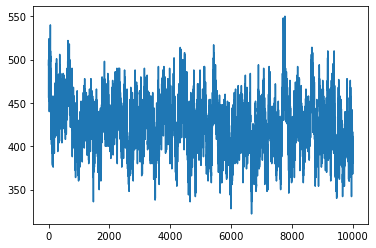

In [10]:
plt.plot(sim.potential_energy)
plt.show

(450.0, 450.0, 1)


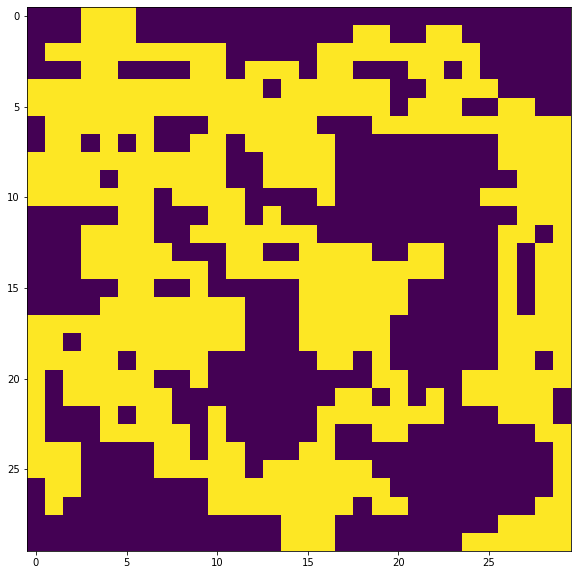

In [22]:
plt.figure(figsize=(10,10))
fig= plt.imshow(sim.system.data)
fig.figure.savefig("pleaseworkgood")
print(sim.system.return_largest_polymer_cluster_area())

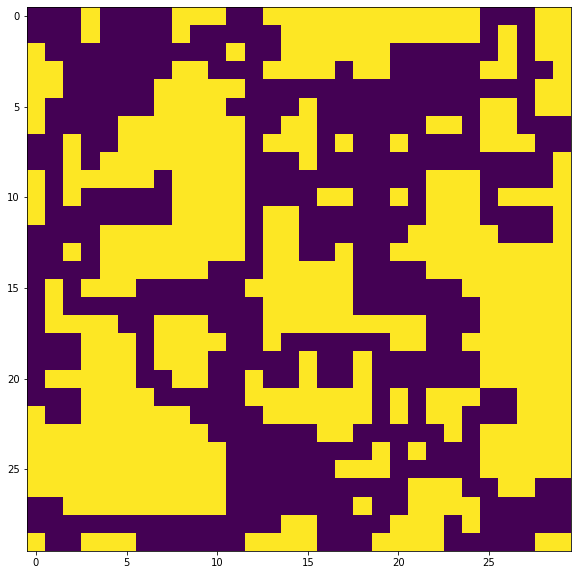

In [11]:
plt.figure(figsize=(10,10))
fig= plt.imshow(sim.system.data)
fig.figure.savefig("pleaseworkgood")


In [159]:
cluster_size = []
for k in range(len(sim.system.trajectory)):
    cluster_size.append(return_largest_polymer_cluster_area(sim.system.trajectory[k]))

<function matplotlib.pyplot.show(close=None, block=None)>

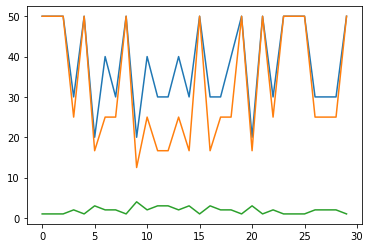

In [164]:
plt.plot(cluster_size)
plt.show

In [8]:
%%time
kt_sweep =[]
for i in range(35):
    
    sim = Simulation(grid_size=10,
                     number_of_polymers = 5,
                     length_of_polymers = 10,
                     warm_up_steps = 10000,
                     wriggles_per_step = 1,
                     steps= 500000,
                     write=10000,
                     kt=.5 + i *.1)
    sim.run()
    kt_sweep.append(sim)

KeyboardInterrupt: 

In [9]:
kt_sweep

0.6

In [10]:
for x in kt_sweep:
    print(x.system.return_largest_polymer_cluster_area())

(50.0, 50.0, 1)
(50.0, 50.0, 1)
(30.0, 25.0, 2)
(29.0, 24.5, 2)
(30.0, 25.0, 2)
(50.0, 50.0, 1)
(50.0, 50.0, 1)
(50.0, 50.0, 1)
(40.0, 25.0, 2)
(40.0, 25.0, 2)
(30.0, 25.0, 2)
(30.0, 25.0, 2)
(40.0, 25.0, 2)


In [12]:
kt_sweep[3].system.data

array([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [20]:
random.randint(0,1)

0

In [115]:
range(5)


range(0, 5)

In [116]:
for i in range(5):
    print(str(i))

0
1
2
3
4


In [17]:
random.uniform(0,1)

0.5091703718192151

In [55]:
sys = System(10)
sys.add_polymers(5,10)

In [56]:
sys.wriggle(10000)

In [57]:
sys.data

array([[0, 0, 3, 3, 4, 4, 4, 1, 1, 1],
       [0, 0, 3, 2, 2, 0, 4, 1, 1, 1],
       [0, 0, 3, 2, 2, 0, 4, 5, 1, 1],
       [0, 3, 3, 3, 2, 2, 4, 5, 1, 1],
       [0, 3, 3, 3, 2, 2, 4, 5, 0, 0],
       [0, 0, 0, 0, 2, 2, 4, 5, 5, 5],
       [0, 0, 0, 0, 0, 0, 4, 0, 0, 5],
       [0, 0, 0, 0, 0, 0, 4, 0, 0, 5],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]])